In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import sklearn.metrics
from lifelines.statistics import logrank_test

from utils import kaplan_curve, plot_confusion_matrix
%matplotlib inline

In [2]:
path = './data/Obituaries_Dataset.csv'
df = pd.read_csv(path)

In [3]:
for var in ["Married", "Color"]:
    df[var] = df[var].str.title()
df = df.replace("None", np.nan)

df["Word_Count"] = df["Word_Count"].str.replace(",", "")
df["Word_Count"] = df["Word_Count"].values.astype(float)

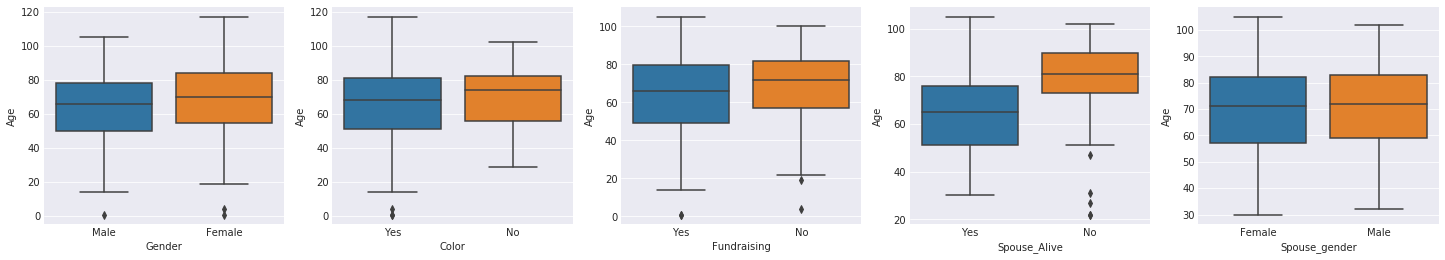

In [4]:
fig, axes = plt.subplots(ncols=5, figsize=[25, 4])

for index, var in enumerate(["Gender", "Color", "Fundraising", "Spouse_Alive", "Spouse_gender"]):
    sns.boxplot(x=var, y="Age", data=df, ax=axes[index])
plt.show()
fig.savefig("boxplot.png", bbox_inches='tight', dpi=500)

In [5]:
# Death has been observed for all the records
df["Censorship"] = 1
df = df.dropna(subset=["Age"])

{'kmf_Female': <lifelines.KaplanMeierFitter: fitted with 228 observations, 0 censored>,
 'kmf_Male': <lifelines.KaplanMeierFitter: fitted with 279 observations, 0 censored>}

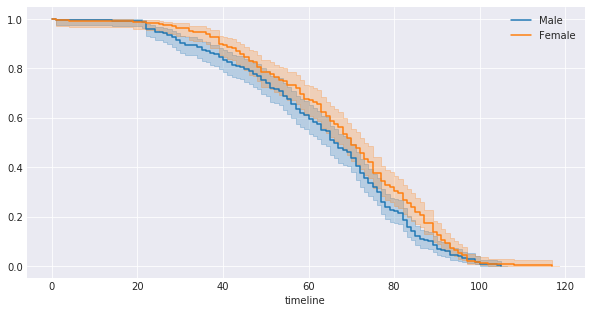

In [6]:
kaplan_curve(df, "Age", "Censorship", "Gender")

Hazard Ratio

In [7]:
alive = (df["Gender"] == "Male")
results = logrank_test(df["Age"][alive], df["Age"][~alive], 
                       df["Censorship"][alive], df["Censorship"][~alive], alpha=0.99 )
results.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p   
        5.6448 0.0175  .
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


In [8]:
Z = results.test_statistic
D = df["Censorship"].sum()

hazard_ratio = np.exp(Z*np.sqrt(4/D))
print(hazard_ratio)

1.6510172989120533


In [9]:
cols = ['Fundraising', 'Gender', 'Age', 'Color', 'Size', 'Word_Count', 'No_of_Children','Significant_Children', 'Significant_Relatives']
df = df.dropna(subset=cols)
df = df[cols]

In [10]:
# Exponential distribution
exp_scaler = MinMaxScaler()
df[['No_of_Children', 'Significant_Children', 'Significant_Relatives']] = exp_scaler.fit_transform(df[['No_of_Children', 'Significant_Children', 'Significant_Relatives']])

# Data with posible outliers
out_scaler = RobustScaler()
df[['Size', 'Word_Count']] = out_scaler.fit_transform(df[['Size', 'Word_Count']])

# Normal distribution
norm_scaler = StandardScaler()
df['Age'] = norm_scaler.fit_transform(df['Age'].values.reshape(-1, 1))

In [11]:
for var in ["Fundraising", "Color"]:
    df[var] = df[var].apply(lambda x: 1 if x== "Yes" else 0)

df["Gender"] = df["Gender"].apply(lambda x: 1 if x== "Male" else 0) 

In [12]:
y = df["Fundraising"]
X = df.drop("Fundraising", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
gridParams = {
    'n_estimators': [10, 100, 500, 1000, 2000, 5000, 7000],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    }

model = ExtraTreesClassifier()

grid_model = RandomizedSearchCV(
    model, gridParams,
    n_iter=30,
    verbose=0,
    scoring='roc_auc',
    cv=4,
    n_jobs=-1
)

grid_model.fit(X_train, y_train)

print(grid_model.best_params_)
print(grid_model.best_score_)


{'n_estimators': 100, 'max_features': 'auto', 'criterion': 'gini'}
0.6462403441963362


In [14]:
#Train on the full training set
model = ExtraTreesClassifier()
model.set_params(**grid_model.best_params_)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [15]:
f1_score = sklearn.metrics.f1_score(y_test, y_pred)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print (f"F1 score = {f1_score}")
print (f"Sensitivity = {sensitivity}")
print (f"Specificity = {specificity}")

F1 score = 0.6344827586206896
Sensitivity = 0.6571428571428571
Specificity = 0.30952380952380953


Normalized confusion matrix
[[0.31 0.69]
 [0.34 0.66]]


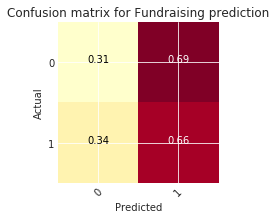

In [16]:
plot_confusion_matrix(y_test, y_pred, [0, 1], True)

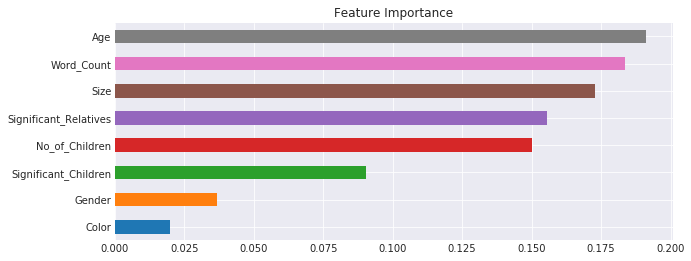

In [24]:
# Plot feature importance
temp = pd.Series(model.feature_importances_, index=X.columns)
temp = temp.sort_values()
fig, ax = plt.subplots(figsize=[10, 4])
temp.plot(kind='barh', ax=ax)
ax.set_title("Feature Importance")
fig.savefig("importance.png", bbox_inches='tight', dpi=500)